# Libraries

In [274]:
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
import datetime
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
import re
import textstat
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')






[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/nikhilramchandani/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nikhilramchandani/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

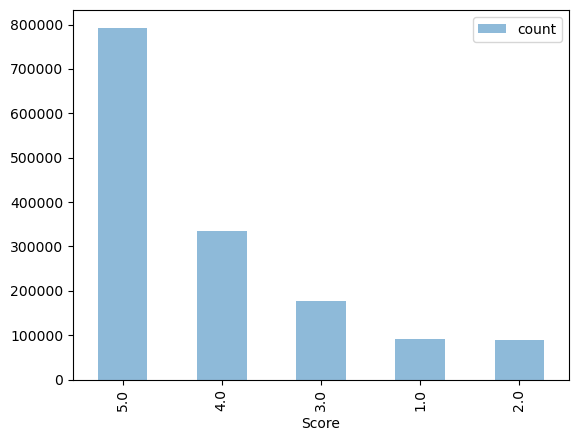


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [275]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features

In [263]:
def add_features_to(df):
    # This is where you can do all your feature extraction

    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)


    df = add_time_features(df)
    df = add_text_length_features(df)
    df = add_summary_length_features(df)
    df = add_helpfulness_ratio(df)
    df = add_sentiment_features(df)
    df = add_pos_features(df)
    df = add_recency_feature(df)
    df = add_summary_text_similarity(df)
    df = add_readability_feature(df)
    df = add_sentence_length_feature(df)

    return df

def handle_missing_values(df):
    # Fill missing values with the median of the column
    df['Text'] = df['Text'].fillna('')
    df['Summary'] = df['Summary'].fillna('')
    return df



def add_time_features(df):
    df['Time'] = pd.to_datetime(df['Time'], unit='s')
    df['Year'] = df['Time'].dt.year
    df['Month'] = df['Time'].dt.month
    df['Day'] = df['Time'].dt.day
    df['DayOfWeek'] = df['Time'].dt.dayofweek
    return df



def add_text_length_features(df):
    df['TextLength'] = df['Text'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)  # Word Count
    df['TextCharCount'] = df['Text'].apply(lambda x: len(x) if isinstance(x, str) else 0)  # Character Count
    df['TextPunctCount'] = df['Text'].apply(lambda x: sum(1 for char in x if char in ['!', '?', '.', ',', ';', ':', '-', '(', ')']) if isinstance(x, str) else 0)  # Punctuation Count
    df['TextUpperCount'] = df['Text'].apply(lambda x: sum(1 for char in x if char.isupper()) if isinstance(x, str) else 0)  # Uppercase Count
    df['TextLowerCount'] = df['Text'].apply(lambda x: sum(1 for char in x if char.islower()) if isinstance(x, str) else 0)  # Lowercase Count
    return df

def add_summary_length_features(df):
    df['SummaryLength'] = df['Summary'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)  # Word Count
    df['SummaryCharCount'] = df['Summary'].apply(lambda x: len(x) if isinstance(x, str) else 0)  # Character Count
    df['SummaryPunctCount'] = df['Summary'].apply(lambda x: sum(1 for char in x if char in ['!', '?', '.', ',', ';', ':', '-', '(', ')']) if isinstance(x, str) else 0)  # Punctuation Count
    return df

def add_helpfulness_ratio(df):
    df['HelpfulnessTextLengthRatio'] = df['Helpfulness'] / (df['TextLength'] + 1)
    df['HelpfulnessSummaryLengthRatio'] = df['Helpfulness'] / (df['SummaryLength'] + 1)
    return df



def add_sentiment_features(df):
    # Check for None values and handle them appropriately
    df['TextSentiment'] = df['Text'].apply(lambda x: TextBlob(x).sentiment.polarity if isinstance(x, str) else 0)
    df['SummarySentiment'] = df['Summary'].apply(lambda x: TextBlob(x).sentiment.polarity if isinstance(x, str) else 0)
    return df


def count_pos_tags(text):
    tokens = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    pos_count = {'nouns': 0, 'verbs': 0, 'adjectives': 0, 'adverbs': 0}
    for word, pos in pos_tags:
        if pos.startswith('N'): pos_count['nouns'] += 1
        elif pos.startswith('V'): pos_count['verbs'] += 1
        elif pos.startswith('J'): pos_count['adjectives'] += 1
        elif pos.startswith('R'): pos_count['adverbs'] += 1
    return pos_count

def add_pos_features(df):
    pos_features = df['Text'].apply(lambda x: count_pos_tags(x) if isinstance(x, str) else {'nouns': 0, 'verbs': 0, 'adjectives': 0, 'adverbs': 0})
    df['NounCount'] = pos_features.apply(lambda x: x['nouns'])
    df['VerbCount'] = pos_features.apply(lambda x: x['verbs'])
    df['AdjectiveCount'] = pos_features.apply(lambda x: x['adjectives'])
    df['AdverbCount'] = pos_features.apply(lambda x: x['adverbs'])
    return df


def add_recency_feature(df):
    current_time = pd.Timestamp(datetime.datetime.now())
    df['Recency'] = (current_time - df['Time']).dt.days
    return df

def add_summary_text_similarity(df):
    vectorizer = TfidfVectorizer()
    text_tfidf = vectorizer.fit_transform(df['Text'].fillna(''))
    summary_tfidf = vectorizer.transform(df['Summary'].fillna(''))
    
    similarity = []
    for i in range(len(df)):
        if text_tfidf[i].nnz > 0 and summary_tfidf[i].nnz > 0:  # Check non-zero vector
            similarity.append(cosine_similarity(text_tfidf[i], summary_tfidf[i])[0][0])
        else:
            similarity.append(0)  # No similarity for empty or non-representative text
    df['TextSummarySimilarity'] = similarity
    return df


def add_readability_feature(df):
    df['TextReadability'] = df['Text'].apply(lambda x: textstat.flesch_kincaid_grade(x) if isinstance(x, str) else 0)
    df['SummaryReadability'] = df['Summary'].apply(lambda x: textstat.flesch_kincaid_grade(x) if isinstance(x, str) else 0)
    return df



def average_sentence_length(text):
    sentences = re.split(r'[.!?]+', text) if isinstance(text, str) else []
    num_sentences = len(sentences)
    total_words = len(text.split()) if isinstance(text, str) else 0
    return total_words / num_sentences if num_sentences > 0 else 0

def add_sentence_length_feature(df):
    df['AvgSentenceLengthText'] = df['Text'].apply(lambda x: average_sentence_length(x))
    df['AvgSentenceLengthSummary'] = df['Summary'].apply(lambda x: average_sentence_length(x))
    return df


def text_clean(df):
    df['Text'] = df['Text'].str.lower()  # Convert to lowercase
    df['Summary'] = df['Summary'].str.lower()  # Convert to lowercase

    # Remove stopwords, special characters, and punctuation
    stopwords = set(['the', 'and', 'is', 'to', 'in', 'that', 'it', 'of', 'for', 'on', 'with'])  # Add more stopwords as needed
    df['Text'] = df['Text'].apply(lambda x: ' '.join([word for word in str(x).split() if word not in stopwords and word.isalnum()]))  # Remove stopwords and punctuation
    df['Summary'] = df['Summary'].apply(lambda x: ' '.join([word for word in str(x).split() if word not in stopwords and word.isalnum()]))  # Remove stopwords and punctuation

    # Stemming
    stemmer = PorterStemmer()
    df['Text'] = df['Text'].apply(lambda x: ' '.join([stemmer.stem(word) for word in str(x).split()]))  # Stemming
    df['Summary'] = df['Summary'].apply(lambda x: ' '.join([stemmer.stem(word) for word in str(x).split()]))  # Stemming

    # Text Feature Transformation using TF-IDF
    tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # Adjust max_features as needed
    tfidf_matrix = tfidf_vectorizer.fit_transform(df['Text']).toarray()
    tfidf_df = pd.DataFrame(tfidf_matrix, columns=tfidf_vectorizer.get_feature_names_out())
    
    # Concatenate TF-IDF features with the original DataFrame
    df = pd.concat([df.reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)


    return df
# Load the feature extracted files if they've already been generated
if exists('./data/X_train.csv'):
    X_train = pd.read_csv("./data/X_train.csv")
if exists('./data/X_submission.csv'):
    X_submission = pd.read_csv("./data/X_submission.csv")

else:
    # Process the DataFrame
    short_trainingSet = trainingSet.head(1000000)
    short_trainingSet = handle_missing_values(short_trainingSet)
    train = add_features_to(short_trainingSet)
    train = text_clean(train)


    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    # The training set is where the score is not null
    X_train =  train[train['Score'].notnull()]

    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)




/var/folders/dk/vyk6_yxx6rx4y27dlhv_cvq80000gn/T/ipykernel_85388/887791581.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Text'] = df['Text'].fillna('')
/var/folders/dk/vyk6_yxx6rx4y27dlhv_cvq80000gn/T/ipykernel_85388/887791581.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Summary'] = df['Summary'].fillna('')
/var/folders/dk/vyk6_yxx6rx4y27dlhv_cvq80000gn/T/ipykernel_85388/887791581.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

NameError: name 'df' is not defined

In [264]:
df.to_pickle('./data/testing_TF-IDF.pkl')

Index(['Id', 'ProductId', 'UserId', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Time', 'Summary', 'Text', 'Score',
       'Helpfulness',
       ...
       'written', 'wrong', 'year', 'yet', 'you', 'young', 'younger', 'your',
       'yourself', 'zombi'],
      dtype='object', length=1036)

# Sample + Split into training and testing set

In [265]:
# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=1/4.0,
    random_state=0
)

In [272]:
features = X_train.columns[X_train.columns != 'Score'].tolist()

['Id', 'ProductId', 'UserId', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Summary', 'Text', 'Helpfulness', 'Year', 'Month', 'Day', 'DayOfWeek', 'TextLength', 'TextCharCount', 'TextPunctCount', 'TextUpperCount', 'TextLowerCount', 'SummaryLength', 'SummaryCharCount', 'SummaryPunctCount', 'HelpfulnessTextLengthRatio', 'HelpfulnessSummaryLengthRatio', 'TextSentiment', 'SummarySentiment', 'NounCount', 'VerbCount', 'AdjectiveCount', 'AdverbCount', 'Recency', 'TextSummarySimilarity', 'TextReadability', 'SummaryReadability', 'AvgSentenceLengthText', 'AvgSentenceLengthSummary', '10', '20', '30', 'abil', 'abl', 'about', 'abov', 'absolut', 'accept', 'across', 'act', 'action', 'actor', 'actress', 'actual', 'ad', 'adapt', 'add', 'addit', 'admit', 'adult', 'adventur', 'after', 'again', 'against', 'age', 'ago', 'agre', 'air', 'alien', 'all', 'allow', 'almost', 'alon', 'along', 'alreadi', 'also', 'although', 'alway', 'am', 'amaz', 'amazon', 'american', 'among', 'amount', 'an', 'ani', 'a

# Feature Selection

In [273]:
features = ['TextLength', 'TextCharCount','TextPunctCount','TextUpperCount', 'TextLowerCount','SummaryCharCount','Day', 'DayOfWeek', 'Helpfulness', 'HelpfulnessTextLengthRatio', 'HelpfulnessSummaryLengthRatio', 'TextSentiment', 'SummarySentiment', 'NounCount', 'VerbCount', 'AdjectiveCount', 'AdverbCount', 'Recency', 'TextSummarySimilarity', 'TextReadability', 'SummaryReadability', 'AvgSentenceLengthText', 'AvgSentenceLengthSummary']
features = X_train.columns[X_train.columns != 'Score'].tolist()
X_train_select = X_train[features]
X_test_select = X_test[features]
X_submission_select = X_submission[features]


print(X_train_select.shape)
print(X_test_select.shape)
print(X_submission_select.shape)

(15000, 1035)
(5000, 1035)
(0, 1035)


/Users/nikhilramchandani/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nikhilramchandani/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nikhilramchandani/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


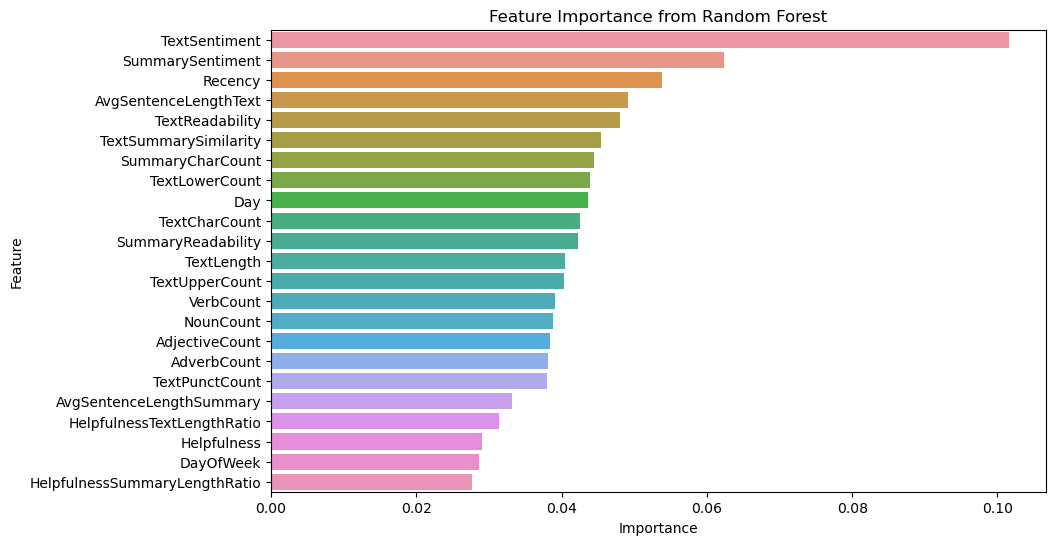

In [269]:
# Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=0)
rf_model.fit(X_train_select, Y_train)

# Get feature importances
importances = rf_model.feature_importances_

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance from Random Forest')
plt.show()



# Model Creation

In [259]:
# Learn the model
model = KNeighborsClassifier(n_neighbors=100).fit(X_train_select, Y_train)

# Predict the score using the model
Y_test_predictions = model.predict(X_test_select)

# Model Evaluation

Accuracy on testing set =  0.5336


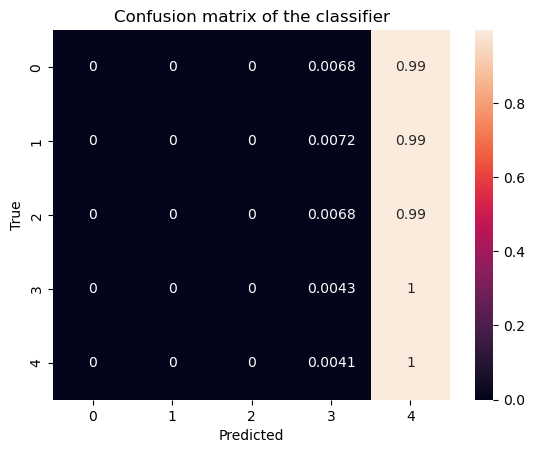

In [260]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [195]:
# Create the submission file
X_submission['Score'] = model.predict(X_submission_select)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)

ValueError: Found array with 0 sample(s) (shape=(0, 7)) while a minimum of 1 is required by KNeighborsClassifier.